In [12]:
# dataset @ https://finance.yahoo.com/quote/MSFT/history/

In [13]:
# Import libraries
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [14]:
# Define the ticker symbol for Microsoft
ticker_symbol = 'MSFT'

# Define the historical date range for data retrieval
start_date = '1986-03-13'
end_date = '2024-10-14'

# Fetch the historical stock data from Yahoo Finance
data = yf.download(ticker_symbol, start=start_date, end=end_date)

# Reset the DataFrame index and store the original index as a new column
# data = data.reset_index()

# Display the last few rows of the DataFrame
data.tail()


[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2024-10-07,416.000000,417.109985,409.000000,409.540009,409.540009,20919800
2024-10-08,410.899994,415.660004,408.170013,414.709991,414.709991,19229300
2024-10-09,415.859985,420.380005,414.299988,417.459991,417.459991,14974300
2024-10-10,415.230011,417.350006,413.149994,415.839996,415.839996,13848400
2024-10-11,416.140015,417.130005,413.250000,416.320007,416.320007,14126600


In [15]:
# Check if the index column 'Date' is in datetime64
data.index.inferred_type == "datetime64"

True

Keep things simple and use univariate forcasting

In [16]:
# Select only the index 'Date' and 'Close' columns from the DataFrame
data = data[['Close']]

# Display the first few rows of the simplified DataFrame
data.head()


,Close
Date,
1986-03-13,0.097222
1986-03-14,0.100694
1986-03-17,0.102431
1986-03-18,0.099826
1986-03-19,0.098090


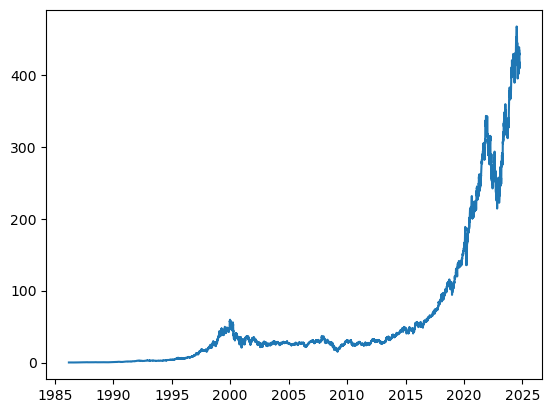

In [17]:
# Plot the data
plt.plot(data.index, data['Close'])

Convert to a supervised learning problem

In [18]:
# Function to create windowed data
def window_data(data, n=3):
    windowed_data = pd.DataFrame()
    
    # Create shifted columns for previous 'Close' values
    for i in range(n, 0, -1):
        windowed_data[f'Close-{i}'] = data['Close'].shift(i)
    
    # Add the current 'Close' column
    windowed_data['Close'] = data['Close']
    
    # Drop rows with NaN values
    return windowed_data.dropna()

# Example usage
windowed_data = window_data(data).reset_index()
windowed_data


,Date,Close-3,Close-2,Close-1,Close
0,1986-03-18,0.097222,0.100694,0.102431,0.099826
1,1986-03-19,0.100694,0.102431,0.099826,0.098090
2,1986-03-20,0.102431,0.099826,0.098090,0.095486
3,1986-03-21,0.099826,0.098090,0.095486,0.092882
4,1986-03-24,0.098090,0.095486,0.092882,0.090278
...,...,...,...,...,...
9716,2024-10-07,417.130005,416.540009,416.059998,409.540009
9717,2024-10-08,416.540009,416.059998,409.540009,414.709991
9718,2024-10-09,416.059998,409.540009,414.709991,417.459991
9719,2024-10-10,409.540009,414.709991,417.459991,415.839996


In [24]:
# Function to transform windowed data into dates, X (features), and Y (targets)
def windowed_data_to_date_x_y(windowed_data):
    # Convert the DataFrame to a NumPy array for easier manipulation
    data = windowed_data.to_numpy()
    
    # Extract the first column (Date) from the NumPy array
    dates = data[:, 0]
    
    # Extract the middle columns (previous 'Close' values) from the NumPy array
    middle_matrix = data[:, 1:-1]
    
    # Reshape the middle matrix to a 3D array suitable for machine learning models
    # (number of samples, number of time steps, number of features)
    x = middle_matrix.reshape((len(dates), middle_matrix.shape[1], 1)).astype(np.float32)
    
    # Extract the second column (current 'Close' value) from the NumPy array as the target variable
    y = data[:, 1].astype(np.float32)
    
    # Return the dates, features (X), and target (Y)
    return dates, x, y


In [25]:
dates, x, y = windowed_data_to_date_x_y(windowed_data)

# Check shapes
dates.shape, x.shape, y.shape

((9721,), (9721, 3, 1), (9721,))

(9721, 3, 1) => We're looking at 3 things in the past for only 1 type of variable

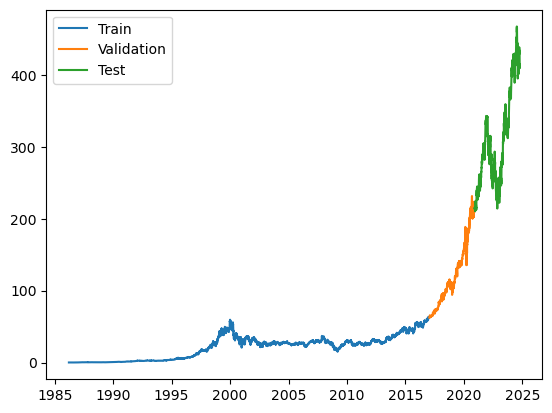

In [30]:
# Define the percentage split indices for training and validation/test sets
q_80 = int(len(dates) * 0.8)  # 80% mark
q_90 = int(len(dates) * 0.9)  # 90% mark

# Split the data into training set (first 80%)
dates_trn, x_trn, y_trn = dates[:q_80], x[:q_80], y[:q_80]

# Split the data into validation set (next 10%)
dates_val, x_val, y_val = dates[q_80:q_90], x[q_80:q_90], y[q_80:q_90]

# Split the data into test set (last 10%)
dates_tst, x_tst, y_tst = dates[q_90:], x[q_90:], y[q_90:]

# Plot the training data
plt.plot(dates_trn, y_trn)

# Plot the validation data
plt.plot(dates_val, y_val)

# Plot the test data
plt.plot(dates_tst, y_tst)

# Add a legend to indicate which line is which set
plt.legend(['Train', 'Validation', 'Test'])
